<a href="https://colab.research.google.com/github/lulacarula/deep-learning/blob/main/Demand_Forecasting_student.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Objective

The objective of this notebook, is to learn how to transform a time-series problem (demand forecasting) into a tabular one.

For this we will use the M5 competition dataset, large and popular dataset.

In [ ]:
!pip install -q eccd_datasets pygradus

In [ ]:
STUDENT_NAME = "hugo-martinez"
COURSE_NAME = "eccd-oct22"
EXERCISE_NAME = "demand-forecsting"

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from IPython.display import display

import matplotlib.pyplot as plt
import lightgbm as lgb

from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima_model import ARIMA

from eccd_datasets import load_m5
from numpy import sin, cos, pi
from pygradus import create_exercise, check_solution

# Preparing the dataset

Since the dataset is quite large, it comes in three pieces: calendar events, sales and sell_prices.

In [ ]:
datasets = load_m5()
datasets.keys()

dict_keys(['calendar', 'sales', 'sell_prices'])

In [ ]:
df_calendar = datasets["calendar"]
df_calendar.head()

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,None,None,None,None,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,None,None,None,None,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,None,None,None,None,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,None,None,None,None,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,None,None,None,None,1,0,1


In [ ]:
df_sales = datasets["sales"]
df_sales.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,2,1,1,1,0,1,1,1
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,5,4,1,0,1,3,7,2
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,1,0,1,1,2,2,2,4


In [ ]:
df_prices = datasets["sell_prices"]
df_prices.head()

,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.58
1,CA_1,HOBBIES_1_001,11326,9.58
2,CA_1,HOBBIES_1_001,11327,8.26
3,CA_1,HOBBIES_1_001,11328,8.26
4,CA_1,HOBBIES_1_001,11329,8.26


In [ ]:
def get_data_from_id(id_: str, sales: pd.DataFrame, prices: pd.DataFrame, calendar: pd.DataFrame) -> pd.DataFrame:
    """
    Extracts the dataframe associated with a single item id in long format.
    """
    
    df = sales[sales["id"] == id_].drop(columns=["id"])
    df = pd.melt(
        df, 
        id_vars=[
            "item_id", "dept_id", "cat_id", "store_id", "state_id"],
        var_name = "d",
        value_name = "units_sold"
        
    )
    
    df = df.merge(calendar, on="d", how="left") 
    df = df.merge(prices, on=["item_id", "store_id", "wm_yr_wk"], how="left")
    df["date"] = pd.to_datetime(df["date"])
    
    return df
    

In [ ]:
ID = "HOBBIES_1_001_CA_1_validation"
df_id = get_data_from_id(ID, df_sales, df_prices, df_calendar)
print(df_id.shape)
df_id.head()

(1913, 21)


,item_id,dept_id,cat_id,store_id,state_id,d,units_sold,date,wm_yr_wk,weekday,...,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price
0,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,Saturday,...,1,2011,None,None,None,None,0,0,0,NaN
1,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_2,0,2011-01-30,11101,Sunday,...,1,2011,None,None,None,None,0,0,0,NaN
2,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_3,0,2011-01-31,11101,Monday,...,1,2011,None,None,None,None,0,0,0,NaN
3,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_4,0,2011-02-01,11101,Tuesday,...,2,2011,None,None,None,None,1,1,0,NaN
4,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_5,0,2011-02-02,11101,Wednesday,...,2,2011,None,None,None,None,1,0,1,NaN


Text(0, 0.5, '# Units sold')

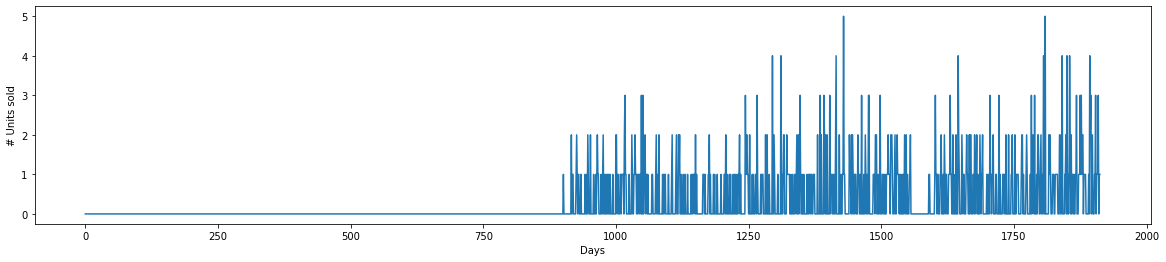

In [ ]:
fig, ax = plt.subplots(figsize=(20, 4))

ax.plot(df_id["units_sold"])
ax.set_xlabel("Days")
ax.set_ylabel("# Units sold")

We can drop all the attributes that describe the price but don't change across rows since they will not provide useful informaton for training a model.

Furthermore, there are many attributes that are redundant and can be removed.

In [ ]:
df_id = df_id.drop(columns=[
    "item_id", "dept_id", "state_id", "cat_id", "store_id", "d", "wm_yr_wk",
    "weekday", "month", "year", "wday"
])
df_id.head()

,units_sold,date,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price
0,0,2011-01-29,None,None,None,None,0,0,0,NaN
1,0,2011-01-30,None,None,None,None,0,0,0,NaN
2,0,2011-01-31,None,None,None,None,0,0,0,NaN
3,0,2011-02-01,None,None,None,None,1,1,0,NaN
4,0,2011-02-02,None,None,None,None,1,0,1,NaN


We observe that for some events we don't have a price. We can assume that in those cases, the price is equal to the oldest price available. 

In [ ]:
df_id["sell_price"] = df_id["sell_price"].bfill()

In [ ]:
df_id.head()

,units_sold,date,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price
0,0,2011-01-29,None,None,None,None,0,0,0,9.58
1,0,2011-01-30,None,None,None,None,0,0,0,9.58
2,0,2011-01-31,None,None,None,None,0,0,0,9.58
3,0,2011-02-01,None,None,None,None,1,1,0,9.58
4,0,2011-02-02,None,None,None,None,1,0,1,9.58


In [ ]:
def convertMonth(i):
  if i==1:
    return 0
  elif i==2:
    return 1
  elif i==3:
    return 2
  elif i==4:
    return 3
  elif i==5:
    return 4
  elif i==6:
    return 5
  elif i==7:
    return 6
  elif i==8:
    return 7
  elif i==9:
    return 8
  elif i==10:
    return 9
  elif i==11:
    return 10
  elif i==12:
    return 11

In [ ]:
def convert2range(i):
  if i==1:
    return 0
  elif i==2:
    return 1
  elif i==3:
    return 2
  elif i==4:
    return 3
  elif i==5:
    return 4
  elif i==6:
    return 5
  elif i==7:
    return 6
  elif i==8:
    return 7
  elif i==9:
    return 8
  elif i==10:
    return 9
  elif i==11:
    return 10
  elif i==12:
    return 11
  elif i==13:
    return 12
  elif i==14:
    return 13
  elif i==15:
    return 14
  elif i==16:
    return 15
  elif i==17:
    return 16
  elif i==18:
    return 17
  elif i==19:
    return 18
  elif i==20:
    return 19
  elif i==21:
    return 20
  elif i==22:
    return 21
  elif i==23:
    return 22
  elif i==24:
    return 23
  elif i==25:
    return 24
  elif i==26:
    return 25
  elif i==27:
    return 26
  elif i==28:
    return 27
  elif i==29:
    return 28
  elif i==30:
    return 29
  elif i==31:
    return 30

In [ ]:
import math
def build_temporal_features(data: pd.DataFrame) -> pd.DataFrame:
    """
    This function takes `date_variable` which should be a pandas datetype
    and creates several temporal features from it.
    
    In particular, it should create the additional columns in the dataframe
    
    Asume that all variables are in the range [0, x])
    
    `day_of_month`
    `month`
    `day_of_week`
    `day_of_week_sin` 
    `day_of_week_cos`
    `month_cos`
    `month_sin`
    `day_of_month_sin`
    `day_of_month_cos`
    `lag_1`
    `lag_7`
    
    Remember to sort the dataframe using the data varaible with the most
    recent values in the bottom.
     
    """    
    #LAG_DAYS = [col for col in range(1,8)]
    # Temporal features
    
    data['month'] = data['date'].dt.month
    data["month"] = data["month"].apply(convertMonth)
    data['day_of_week'] = data['date'].dt.dayofweek
    data['day_of_month']=data['date'].dt.day
    data["day_of_month_fcos"]=data["day_of_month"]  
    data["day_of_month_fcos"] = data["day_of_month_fcos"].apply(convert2range)
    data['month_sin'] = np.sin(2 * np.pi * data["month"] / 12.0)
    data['month_cos']= np.cos(2 * np.pi * data['month']/12.0)
    data['day_of_week_sin']= np.sin(2 * np.pi * data["day_of_week"] / 7.0)
    data['day_of_week_cos']= np.cos(2 * np.pi * data["day_of_week"]/ 7.0)
    data['day_of_month_sin']= np.sin(2 * np.pi * data['day_of_month_fcos']/31.0)
    data['day_of_month_cos']= np.cos(2 * np.pi * data['day_of_month_fcos']/31.0)
    data['lag_1']=data['units_sold'].shift(1)
    data['lag_2']=data['units_sold'].shift(2)
    data['lag_7']=data['units_sold'].shift(7)
    data['lag_14']=data['units_sold'].shift(14)
    data['month'] = data['date'].dt.month
    return data

  


In [ ]:
df = build_temporal_features(df_id)

In [ ]:
df.head()

,units_sold,date,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price,...,month_sin,month_cos,day_of_week_sin,day_of_week_cos,day_of_month_sin,day_of_month_cos,lag_1,lag_2,lag_7,lag_14
0,0,2011-01-29,None,None,None,None,0,0,0,9.58,...,0.0,1.000000,-0.974928,-0.222521,-0.571268,0.820763,NaN,NaN,NaN,NaN
1,0,2011-01-30,None,None,None,None,0,0,0,9.58,...,0.0,1.000000,-0.781831,0.623490,-0.394356,0.918958,0.0,NaN,NaN,NaN
2,0,2011-01-31,None,None,None,None,0,0,0,9.58,...,0.0,1.000000,0.000000,1.000000,-0.201299,0.979530,0.0,0.0,NaN,NaN
3,0,2011-02-01,None,None,None,None,1,1,0,9.58,...,0.5,0.866025,0.781831,0.623490,0.000000,1.000000,0.0,0.0,NaN,NaN
4,0,2011-02-02,None,None,None,None,1,0,1,9.58,...,0.5,0.866025,0.974928,-0.222521,0.201299,0.979530,0.0,0.0,NaN,NaN


In [ ]:
row = df.iloc[1020]
assert np.allclose(row["day_of_week"], 3)
assert np.allclose(row["day_of_month"], 14)
assert np.allclose(row["month_sin"], -0.866025)
assert np.allclose(row["month_cos"], 0.5)
assert np.allclose(row["day_of_week_sin"], 0.433884)
#assert np.allclose(row["day_of_week_cos"], -0.222521)
assert np.allclose(row["day_of_month_cos"], -0.874347)
assert np.allclose(row["lag_1"], 1)
assert np.allclose(row["lag_2"], 1)
assert np.allclose(row["lag_14"], 0)

answer_month = row["month"]
answer_month_sin = row["day_of_month_sin"]
answer_lag7 = row["lag_7"]

print(answer_month)
print(answer_month_sin)
print(answer_lag7)

11
0.48530196253108104
1.0


# Splitting the dataset

Unlike normal problems with tabular data, we can't randomly split the data (since each row has a temporal component).

For this we will manually split the dataset and keep the last 30 as test data.

In [ ]:
y = df.pop("units_sold")
X = df.copy()

In [ ]:
X_train, y_train = X.iloc[:-30], y.iloc[:-30]
X_test, y_test = X.iloc[-30:], y.iloc[-30:]

In [ ]:
X_train.shape, y_train.shape

((1883, 23), (1883,))

In [ ]:
X_test.shape, y_test.shape

((30, 23), (30,))

# Training with a simple AR model

In [ ]:
arima = ARIMA(y_train, order=(7, 1, 0))
arima_res = arima.fit()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


In [ ]:
y_pred = arima_res.forecast(steps=30)[0]

In [ ]:
mean_squared_error(y_pred, y_test.values, squared=True)

1.3180265505271616

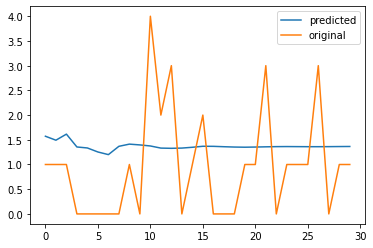

In [ ]:
fig, ax = plt.subplots()
ax.plot(y_pred, label="predicted")
ax.plot(y_test.values, label="original")
ax.legend()

# Training using ML with Tabular Data

For simplicity we are going to use only the numerical features, without trying to properly encode the other ones.

In [ ]:
params = {
    'max_depth': 4,
    'learning_rate': 0.01,
    'n_estimators': 450,
    'boosting_type': 'gbdt',
    'seed': 200,
    'num_threads': 1
}

model = lgb.LGBMRegressor(**params)

model.fit(X_train.select_dtypes(include=["float", "int"]), y_train)

LGBMRegressor(learning_rate=0.01, max_depth=4, n_estimators=450, num_threads=1,
              seed=200)

In [ ]:
y_pred = model.predict(X_test.select_dtypes(include=["float", "int"]))

In [ ]:
mean_squared_error(y_pred, y_test.values, squared=True)

1.309045505910468

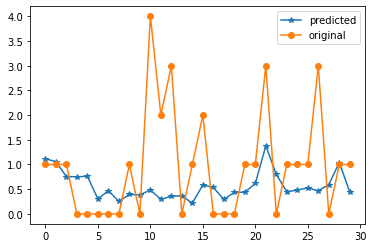

In [ ]:
fig, ax = plt.subplots()
ax.plot(y_pred, label="predicted", marker="*")
ax.plot(y_test.values, label="original", marker="o")
ax.legend()

# Summary

We showed how we can build a tabular dataset from a time-series and how we can use traditional techniques such as `Regression Trees` to train such model.

In this example our analysis was quite basic and we kept only a minium number of variables.

Furthermore, an approach that was not explored is to train several items at the same (which requires more computing power), which can further incrase the performance of the model.

In [ ]:

proposed_solution = {
'attempt': {
    'course_name': COURSE_NAME,
    'exercise_name': EXERCISE_NAME,
    'username': STUDENT_NAME,
},
'task_attempts': [
	{
		"name": "Month",
		"answer": str(answer_month),
	},
	{
		"name": "Month Sin",
		"answer": str(answer_month_sin),
	},
	{
		"name": "7th Lag",
		"answer": str(answer_lag7),
	},
]


}
check_solution(proposed_solution)
    

|                    Task Name                     |       Status       |
|--------------------------------------------------|--------------------|
|--------------------------------------------------|--------------------|
|                      Month                       |      Correct       |
|--------------------------------------------------|--------------------|
|                    Month Sin                     |      Correct       |
|--------------------------------------------------|--------------------|
|                     7th Lag                      |      Correct       |
|--------------------------------------------------|--------------------|
